In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats
from scipy.stats import iqr
import matplotlib.pyplot as plt

data_path = '../../data/data_v2/'
model_path = './model/'

def norm_err(y_test, p_test):
    """
    Calculates the normalized error between a true and predicted reference interval as proposed in CA-125 paper submitted to Sci. Reports
    
    Arguments:
        y_test:   true RI
        p_test:   predicted RI
        
    Returns:
        normalized error
    """
    return np.mean([np.abs(i-j) for i,j in zip([-1, 1], (p_test-y_test.mean())/y_test.std())])/2


In [2]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [3]:
# load data
test_x = pickle.load(open(data_path+'x_test.pkl', 'rb'))
test_y = pickle.load(open(data_path+'y_test.pkl', 'rb'))

test_x = [np.array(i) for i in test_x]


In [4]:
# scale data

data_means = [i.mean() for i in test_x]
data_std = [i.std() for i in test_x]
data_scaled = [(i-i.mean())/i.std() for i in test_x]


In [5]:
# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))


In [6]:
# extract features
features = np.array([extract_features(i) for i in data_scaled])
features.shape


(1000, 100, 1)

In [7]:
# predict
test_p = model.predict(features)
test_p = scalery.inverse_transform(test_p)


32/32 [==============================] - 1s 2ms/step


In [8]:
len(np.where(np.isnan(test_p))[0])


0

In [9]:
# standardize target RIs
test_y_scaled = [(i-j)/k for i,j,k in zip(test_y, data_means, data_std)]


In [10]:
# get central 95% RIs
test_p_ris = [i[[1, -3]] for i in test_p]
test_y_ris = [i[[1, -2]] for i in test_y_scaled]


In [11]:
errors = [norm_err(i, j) for i,j in zip(test_y_ris, test_p_ris)]
errors = np.array(errors)


In [12]:
np.mean(errors)


0.05097219327837229

In [13]:
np.median(errors)


0.03587949275970459

In [14]:
error_threshold = 0.2
len(np.where(errors<=error_threshold)[0])/len(errors)


0.985

In [15]:
error_threshold = 0.1
len(np.where(errors<=error_threshold)[0])/len(errors)


0.881

In [16]:
# plt.hist(errors, 100, alpha=0.5, edgecolor='k');


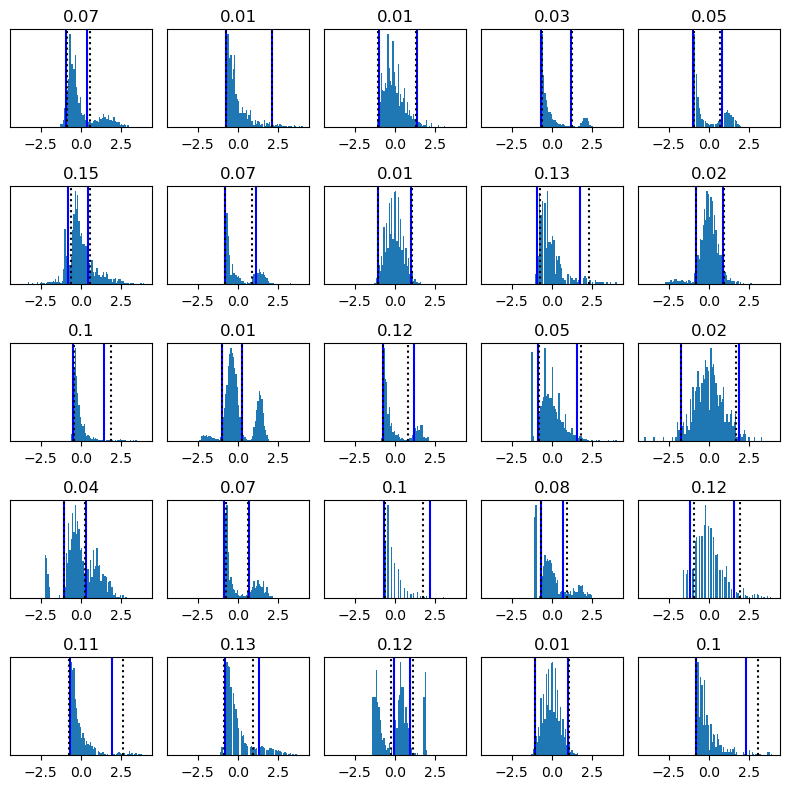

In [18]:
nr = 5
nc = 5
idx = np.random.choice(len(errors), nr*nc)
idx = np.load('../../evaluation/simulated/example_idx.npy')
# idx = np.random.choice(np.where(errors>0.20)[0], nr*nc)
plt.figure(figsize=(8, 8))
for c,i in enumerate(idx):
    plt.subplot(nr, nc, c+1)
    plt.hist(data_scaled[i], np.linspace(-4, 4, 101), density=True);
    for j in test_p_ris[i]:
        plt.axvline(j, c='b')
    for j in test_y_ris[i]:
        plt.axvline(j, c='k', linestyle=':')
    plt.yticks([])
    plt.title(round(errors[i], 2))
plt.tight_layout()


In [ ]:
idx[-2]

In [ ]:
test_p[idx[-2]][-1]


In [ ]:
plt.hist(test_x[818], np.linspace(-8, 8, 100));
for j in range(2):
    plt.axvline(test_y_ris[818][j], c='k', linestyle=':')
    plt.axvline(test_p_ris[818][j], c='r', linestyle=':')
    